In [283]:
from sklearn.base import BaseEstimator
#import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Lasso, Ridge, ElasticNet,LogisticRegression


class CustomEnsemble(object):
    '''
    Xarg = np.array([range(10),range(0,20,2)])
    yarg = np.array([0,0,0,0,0,1,1,1,1,1])
    
    ce = CustomEnsemble(Xarg.T, yarg.T)
    ce.grid_search_layer1('mod1', DefinedModels._xgb_classifier, DefinedModels._xgb_classifier_def_par)
    ce.grid_search_layer1('mod2', DefinedModels._svc ,  DefinedModels._svc_def_par  )
    ce.grid_search_layer1('mod3', DefinedModels._gaussian_process,  DefinedModels._gaussian_process_def_par)
    ce.grid_search_layer1('mod4', DefinedModels._randomforest_classifier, DefinedModels._randomforest_classifier_def_par  )
    
    ce.set_layer1_from_gridsearch('mod1')
    ce.set_layer1_from_gridsearch('mod2')
    ce.set_layer1_from_gridsearch('mod3')
    ce.set_layer1_from_gridsearch('mod4')
    
    
    ce.grid_search_layer2('mod5', DefinedModels._decesiontree_classifier, DefinedModels._decesiontree_classifier_def_par  )
    ce.set_layer2_from_gridsearch('mod5')
    
    Xtest = np.array([range(5, 15),range(10,30,2)])
    ce.predict(Xtest.T)
    
    '''
    
    def __init__(self, X = None, y= None,_Xtest = None, ytest= None):
        self._model_layer1 = {}
        self._model_layer2 = {}
        self._grid_searches = {}
        self._grid_searches2 = {}
        self._X = X
        self._y = y
        self._Xtest = _Xtest
        self._ytest = ytest

         
    def predict(self, X_to_predict, name=None):
        if name is None:
            return self._predict_layer_2(self._predict_layer1(X_to_predict))
        else:
            return self.best_estimator(name).predict(X_to_predict)
    
    def grid_search_layer1(self, name, model, parameter = {}, scoring = None):
        
        self._grid_searches[name] = GridSearchCV(estimator = model, param_grid = parameter, cv=5, scoring = scoring)
        if self._X is not None and self._y is not None:
            self._grid_searches[name].fit(self._X, self._y)
            return self._grid_searches[name].cv_results_
        else: 
            raise Exception('No any data was given')
            
    def grid_search_layer2(self, name, model, parameter = {}, scoring = None):
        
        #self._predict_layer1()
        self._grid_searches2[name] = GridSearchCV(estimator = model, param_grid = parameter,scoring = scoring)
        if self._dataset_blend_train is not None and self._y is not None:
            self._grid_searches2[name].fit(self._dataset_blend_train, self._y)
            return self._grid_searches2[name].cv_results_
        else: 
            raise Exception('No any data was given')
            
    def set_layer1(self,*model):
        self._set_layer(self._model_layer1, model)
        
    def set_layer2(self,*model):
        self._set_layer(self._model_layer2, model)
        
    def set_layer1_from_gridsearch(self, *names):
        
        args = [(name, self.best_estimator(name)) for name in names]
        self.set_layer1(*args)
        self._predict_layer1()
        
    def set_layer2_from_gridsearch(self, *names):
        
        args = [(name, self.best_estimator(name)) for name in names]
        self.set_layer2(*args)
        
    def _get_gridsearch_model(self,name):
        if name in self._grid_searches:
            return self._grid_searches[name]
        elif name in self._grid_searches2:
            return self._grid_searches2[name]
        else:
            raise Exception('this name is not valid'+name)
        
    def best_score(self, name):
        return self._get_gridsearch_model(name).best_score_
            
    def best_estimator(self, name):
        return self._get_gridsearch_model(name).best_estimator_
    
    def feature_importance(self, name, print_list = True, plot = False):

        model = self.best_estimator(name)
        if not hasattr(model, "feature_importances_"):
            print("Feature doesnt have feature_importances_ attr")
            return
        if print_list:
            print(model.feature_importances_)
        if plot:
            import matplotlib.pyplot as plt
            %matplotlib inline
            x = range(len(model.feature_importances_))
            plt.figure(figsize=(15,5))
            plt.bar(x, model.feature_importances_)
            xdataset = self._get_x_train(name)
            cols = xdataset.columns if hasattr(xdataset, "columns") else list(range(0,len(xdataset)))
            plt.xticks(x, cols, rotation=80)
            
    def confusion_matrix(self, name):
        try:
            from sklearn.metrics import confusion_matrix
            x = self._get_x_test(name)
            print(len(x))
            prediction = self.predict(  x, name)
            print(len(prediction))
            print(len(self._ytest))
            CM = confusion_matrix(y_test, prediction)
            TN = CM[0][0]
            FN = CM[1][0]
            TP = CM[1][1]
            FP = CM[0][1]
            print("TN", TN,"\tFP", FP)
            print("FN", FN,"\tTP", TP)
            #print(CM)
            #print(TN/(TN+FP), TP/(TP+FN))
        except Exception as e:
            raise Exception('Name is not valid or problem at validation'+name, e)
        
    def get_report(self, name):
        
        #base score print
        print("best trained score: {0}".format(self.best_score(name)))
        
        #print feature importance report
        self.feature_importance(name, False, True)
        
        #print confusion matrix 
        self.confusion_matrix(name)
    


            
    ####################
    
    def _get_x_test(self, name):
        if name in self._grid_searches:
            return self._Xtest
        elif name in self._grid_searches2:
            return  self._dataset_blend_test if self._dataset_blend_test is not None else None
        else:
            return None
    def _get_x_train(self, name):
        if name in self._grid_searches:
            return self._X
        elif name in self._grid_searches2:
            return  self._dataset_blend_train if self._dataset_blend_train is not None else None
        else:
            return None
    
    def _predict_layer_2(self, dataset_blend_train):
        
        for i,keymodel in enumerate(self._model_layer2.items()):
            print('predict for model: ', keymodel[0])
            return keymodel[1].predict(dataset_blend_train)
        
    
    def _predict_layer1(self, x = None):
        
        
        if x is None:
            
            self._dataset_blend_train = np.zeros((self._X.shape[0], len(self._model_layer1.items())))
            for i,keymodel in enumerate(self._model_layer1.items()):
                print('predict for model: ', keymodel[0])
                if hasattr(keymodel[1],"predict_proba"):
                    self._dataset_blend_train[:, i] = keymodel[1].predict_proba(self._X)[:,1]
                else:
                    self._dataset_blend_train[:, i] = keymodel[1].predict(self._X)
                print(keymodel[1].predict(self._X)[:10])
                
            self._dataset_blend_test = np.zeros((self._Xtest.shape[0], len(self._model_layer1.items())))
            for i,keymodel in enumerate(self._model_layer1.items()):
                print('predict for model: ', keymodel[0])
                if hasattr(keymodel[1],"predict_proba"):
                    self._dataset_blend_test[:, i] = keymodel[1].predict_proba(self._Xtest)[:,1]
                else:
                    self._dataset_blend_test[:, i] = keymodel[1].predict(self._Xtest)
        else:
        
            result = np.zeros((x.shape[0], len(self._model_layer1.items())))
            for i,keymodel in enumerate(self._model_layer1.items()):
                print('predict for model: ', keymodel[0])
                if hasattr(keymodel[1],"predict_proba"):
                    result[:, i] = keymodel[1].predict_proba(x)[:,1]
                else:
                    result[:, i] = keymodel[1].predict(x)
            return result
        
            
            
    def _set_layer(self,layer, *model):
        iterate = model
        print("set_layer ", model)
        if model[0][0]:
            if isinstance(model[0][0], tuple):
                iterate = list(*model)
        else:
             raise Exception('No any argument')
        
        for model_i_name, model_i in iterate:
            if isinstance(model_i, BaseEstimator):
                layer[model_i_name] = model_i
            else:
                raise Exception('The given model is not from BaseEstimator')
        



class DefinedModels(object):
    
    #_xgb_regressor = xgb.XGBRegressor()
    #_xgb_regressor_def_par = {'max_depth': [2,4,6],
     #                           'n_estimators': [50,100,200]}
    #_xgb_classifier = xgb.XGBClassifier()
    #_xgb_classifier_def_par =  {'max_depth': [2,4,6],
    #                            'n_estimators': [50,100,200]}
    
    _svc = SVC(kernel="linear", C=0.025)
    _svc_def_par =  {'C': [0.025, .5, 1],
                        'kernel': ["linear"],
                        'gamma': [1,2]}
    
    
    _gaussian_process = GaussianProcessClassifier()
    _gaussian_process_def_par =  {"max_iter_predict": [100,500,1000]}
    
    _gaussian_naivebayes = GaussianNB()
    
    _decesiontree_classifier = DecisionTreeClassifier(max_depth=5)   
    _decesiontree_classifier_def_par = {'max_depth': [3,4,5,6]}
    
    _randomforest_classifier = RandomForestClassifier()
    _randomforest_classifier_def_par = {'max_depth': [3,4,5,6],
                                'n_estimators': [50,100,200],
                                "criterion": ["gini", "entropy"]}
    
    
    _mlp_classifier = MLPClassifier()
    _mlp_classifier_def_par = {'hidden_layer_sizes': [(5, 2), (10, 2), (15, 2)]}
    
    _logistic_regression = LogisticRegression()
    _logistic_regression_def_par = {'max_iter': [100, 500, 1000]}
    _lasso = Lasso()
    
    _lasso_def_par =  {'max_iter': [100, 500, 1000]}
    
    _ridge = Ridge()
    _ridge_def_par =  {'solver': ['auto','lsqr','svd']}
    
    _elasticnet = ElasticNet()
    _elasticnet_def_par =  {'max_iter': [100, 500, 1000]}
    
    
    
       
    def __init__(self):
        pass
    
if __name__=='__main__2':
    Xarg = np.array([range(10),range(0,20,2)])
    yarg = np.array([0,0,0,0,0,1,1,1,1,1])
    
    ce = CustomEnsemble(Xarg.T, yarg.T)
    #ce.grid_search_layer1('mod1', DefinedModels._xgb_classifier, DefinedModels._xgb_classifier_def_par)
    ce.grid_search_layer1('mod2', DefinedModels._svc ,  DefinedModels._svc_def_par  )
    ce.grid_search_layer1('mod3', DefinedModels._gaussian_process,  DefinedModels._gaussian_process_def_par)
    ce.grid_search_layer1('mod4', DefinedModels._randomforest_classifier, DefinedModels._randomforest_classifier_def_par  )
    
    #ce.set_layer1_from_gridsearch('mod1')
    ce.set_layer1_from_gridsearch('mod2')
    ce.set_layer1_from_gridsearch('mod3')
    ce.set_layer1_from_gridsearch('mod4')
    
    
    ce.grid_search_layer2('mod5', DefinedModels._decesiontree_classifier, DefinedModels._decesiontree_classifier_def_par  )
    ce.set_layer2_from_gridsearch('mod5')
    
    Xtest = np.array([range(5, 15),range(10,30,2)])
    print(ce.predict(Xtest.T))

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [144]:
import pandas as pd

In [184]:
df = pd.read_csv("dr.csv", header = None,names=["c" + str(each) for each in range(1,21)])
train_cols = ["c" + str(each) for each in range(1,20)]
test_col = "c20"
df.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20
0,1,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1


In [284]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[train_cols], df[test_col], test_size=0.3, random_state=42)
print(len(X_train),len(X_test))
ce = CustomEnsemble(X_train, y_train, X_test, y_test)

805 346


best trained score: 0.6931677018633541
346
346
346
TN 126 	FP 29
FN 80 	TP 111


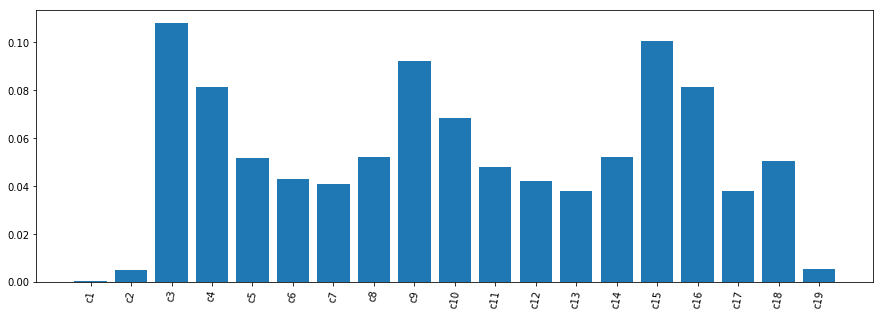

In [285]:
ce.grid_search_layer1('mod4', DefinedModels._randomforest_classifier, DefinedModels._randomforest_classifier_def_par  )
ce.get_report('mod4')

In [286]:
ce.grid_search_layer1('mod2', DefinedModels._logistic_regression ,  DefinedModels._logistic_regression_def_par  )
ce.get_report('mod2')

best trained score: 0.7403726708074534
Feature doesnt have feature_importances_ attr
346
346
346
TN 129 	FP 26
FN 60 	TP 131


In [278]:
ce.grid_search_layer1('mod3', DefinedModels._gaussian_process,  DefinedModels._gaussian_process_def_par)
ce.get_report('mod3')

best trained score: 0.6149068322981367
Feature doesnt have feature_importances_ attr
346
346
346
TN 102 	FP 53
FN 92 	TP 99


In [279]:
ce.set_layer1_from_gridsearch('mod4', 'mod2', 'mod3')

set_layer  ((('mod4', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)), ('mod2', SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('mod3', GaussianProcessClassifier(copy_X_train=True, kernel=None,
             max_iter_predict=100, multi_class='one_vs_rest', n_jobs=1,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=False))),)
predict for model:  mod4
[1 1 0 0 0 1 0 1 1 0]
predict for model

best trained score: 1.0
346
346
346
TN 14 	FP 141
FN 14 	TP 177


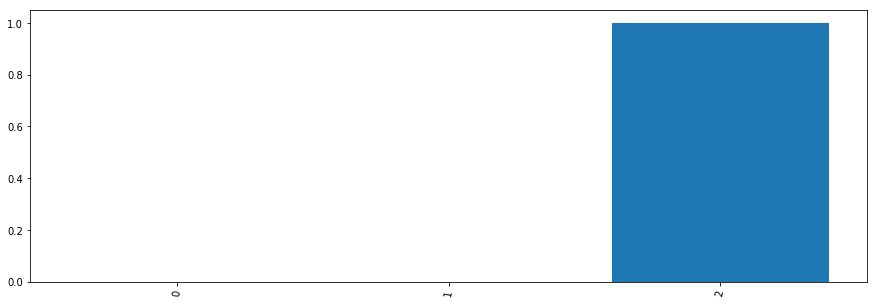

In [280]:
ce.grid_search_layer2('mod5', DefinedModels._decesiontree_classifier, DefinedModels._decesiontree_classifier_def_par  )
ce.get_report('mod5')


In [281]:
ce.grid_search_layer2('mod6', DefinedModels._svc ,  DefinedModels._svc_def_par  )
ce.get_report('mod6')

best trained score: 1.0
Feature doesnt have feature_importances_ attr
346
346
346
TN 112 	FP 43
FN 57 	TP 134


In [282]:
ce._dataset_blend_train[:20,:]

array([[0.83756869, 1.        , 0.58470728],
       [0.89141372, 1.        , 0.58470728],
       [0.39269998, 0.        , 0.58470728],
       [0.39536047, 0.        , 0.41529271],
       [0.47338135, 1.        , 0.41529271],
       [0.95603009, 1.        , 0.58470728],
       [0.31984757, 0.        , 0.58480213],
       [0.64064127, 0.        , 0.58470728],
       [0.50013868, 0.        , 0.41529271],
       [0.4474191 , 0.        , 0.41529269],
       [0.54393747, 0.        , 0.58470728],
       [0.34450284, 0.        , 0.41529271],
       [0.44699141, 0.        , 0.58464417],
       [0.31542434, 0.        , 0.58470728],
       [0.52261529, 0.        , 0.41530896],
       [0.4450738 , 0.        , 0.41529773],
       [0.35140638, 0.        , 0.41529271],
       [0.31539898, 0.        , 0.41529271],
       [0.43777533, 1.        , 0.58470572],
       [0.59095035, 1.        , 0.64282769]])

In [213]:
ce.predict(X_test, 'mod4')[:20]

array([0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1])

In [212]:
ce.predict(X_test, 'mod3')[:20]

array([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1])

In [211]:
ce.predict(X_test, 'mod2')[:20]

array([0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1])

In [207]:
X_test[:5]

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19
174,1,0,13,13,13,12,11,6,31.004416,14.292234,0.994879,0.047469,0.000000,0.000000,0.000000,0.000000,0.549666,0.133508,0
752,1,1,57,56,54,49,47,34,61.390836,29.776641,6.198290,0.424877,0.009203,0.000000,0.000000,0.000000,0.554045,0.110437,0
467,1,1,60,59,57,55,49,33,50.255300,35.387606,13.522807,4.267279,1.945694,0.374350,0.041594,0.000000,0.523895,0.132486,0
240,1,1,48,48,48,48,41,30,34.032933,13.431057,6.029475,1.524910,0.328994,0.000000,0.000000,0.000000,0.539868,0.106026,0
667,1,0,27,27,27,25,23,19,10.707966,4.548286,1.382068,0.074913,0.009173,0.007644,0.004587,0.004587,0.506331,0.107019,1


In [209]:
ce._Xtest[:5]

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19
174,1,0,13,13,13,12,11,6,31.004416,14.292234,0.994879,0.047469,0.000000,0.000000,0.000000,0.000000,0.549666,0.133508,0
752,1,1,57,56,54,49,47,34,61.390836,29.776641,6.198290,0.424877,0.009203,0.000000,0.000000,0.000000,0.554045,0.110437,0
467,1,1,60,59,57,55,49,33,50.255300,35.387606,13.522807,4.267279,1.945694,0.374350,0.041594,0.000000,0.523895,0.132486,0
240,1,1,48,48,48,48,41,30,34.032933,13.431057,6.029475,1.524910,0.328994,0.000000,0.000000,0.000000,0.539868,0.106026,0
667,1,0,27,27,27,25,23,19,10.707966,4.548286,1.382068,0.074913,0.009173,0.007644,0.004587,0.004587,0.506331,0.107019,1


In [215]:
ce._ytest[:20]

174     0
752     0
467     0
240     0
667     0
218     0
867     0
420     1
351     0
328     0
692     1
1041    1
921     1
265     0
754     0
485     1
925     0
289     1
220     0
868     1
Name: c20, dtype: int64

In [169]:
y_test

174     0
752     0
467     0
240     0
667     0
218     0
867     0
420     1
351     0
328     0
692     1
1041    1
921     1
265     0
754     0
485     1
925     0
289     1
220     0
868     1
839     0
543     0
707     1
936     0
583     0
570     1
893     1
101     1
1142    0
352     1
       ..
92      1
916     1
319     1
838     0
280     1
1015    1
650     1
768     1
182     1
688     0
477     1
110     0
989     1
1001    1
578     0
533     0
1114    1
913     1
261     1
1112    1
587     1
605     0
582     0
937     1
137     1
931     0
1054    0
961     1
617     0
714     0
Name: c20, Length: 346, dtype: int64

In [142]:
ce.set_layer2_from_gridsearch('mod5')

set_layer  ((('mod5', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')),),)


In [143]:
ce.predict(X_train)

predict for model:  mod2
predict for model:  mod3
predict for model:  mod4
predict for model:  mod5


array([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,